# Problem Description
RMC, Inc., is a small firm that produces a variety of chemical products. In a particular production process, three raw materials are blended (mixed together) and heated to 300 degrees farenheight to produce two products:  a fuel additive and a solvent base. Each ton of fuel additive is a mixture of 0.4 tons of material 1 and 0.6 tons of material 3. A ton of solvent base is a mixture of 0.5 tons of material 1, 0.2 tons of  material 2, and 0.3 tons of material 3. After deducting relevant costs, the profit contribution is 40 dollars for every ton of fuel additive produced and 38 dollars for every ton of solvent base produced. RMC has two mixing units available for production 6 hours a day Monday through Friday. Both units can mix solvent base or fuel additive. The newer mixer 1 rate is faster than that of the older mixer 2 unit. RMC’s production is constrained by a limited availability of the three raw materials and the available operating time on each product mixer. 

The planning deparment it working to determine the production plan for the coming week provided the current pricing, currrent availability of raw materials, and considering that Mixer 2 will be down for one day due to maintenance needs. 

Problem is a revision taken from Anderson, David R.; Sweeney, Dennis J.; Williams, Thomas A.; Camm, Jeffrey D.; Cochran, James J.. An Introduction to Management Science: Quantitative Approach (p. 63). Cengage Learning. 

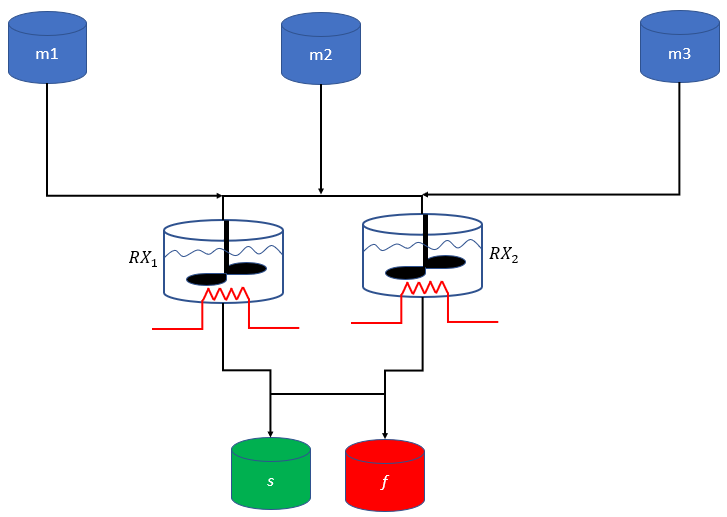

# Problem Definition
* Solvent base generates a profit of 38 dollars per ton and fuel additive generates a profit of 40 dollars per ton. 
* One ton of solvent base requires 0.5 tons of Material 1, 0.2 tons of Material 2, and 0.3 tons of Material 3. 
* One ton of fuel additive requires 0.4 tons of Material 1 and 0.6 tons of Material 3.
* Profits are maximized for a single period. No multiperiod sales are considered. 
* Raw material availability is limited to 20 tons of Material 1, 5 tons of Material 2, and 21 tons of Material 3. 
* The mixer 1 production rates for solvent base and fuel additive are 0.65 tons/hour and 0.5 tons/hour, respectively.
* The mixer 2 production rates for solvent base and fuel additive are 0.6 tons/hour and 0.45 tons/hour, respectively.
* The total production time available for mixer 1 is 30 hours and for mixer 2 it is 24 hours. Mixer 2 has scheduled maintenance on day of the week and will be unavailable  (6 hours of lost production time). 
* Additional material is not available for purchase.
* Additional operating time for each mixer is not available due to manpower/scheduling. 

# Opportunity Statement
Maximize profit by determining how much of each product, solvent base and fuel additive, to produce with the raw materials and product mixer capacities available. 

# Model Development

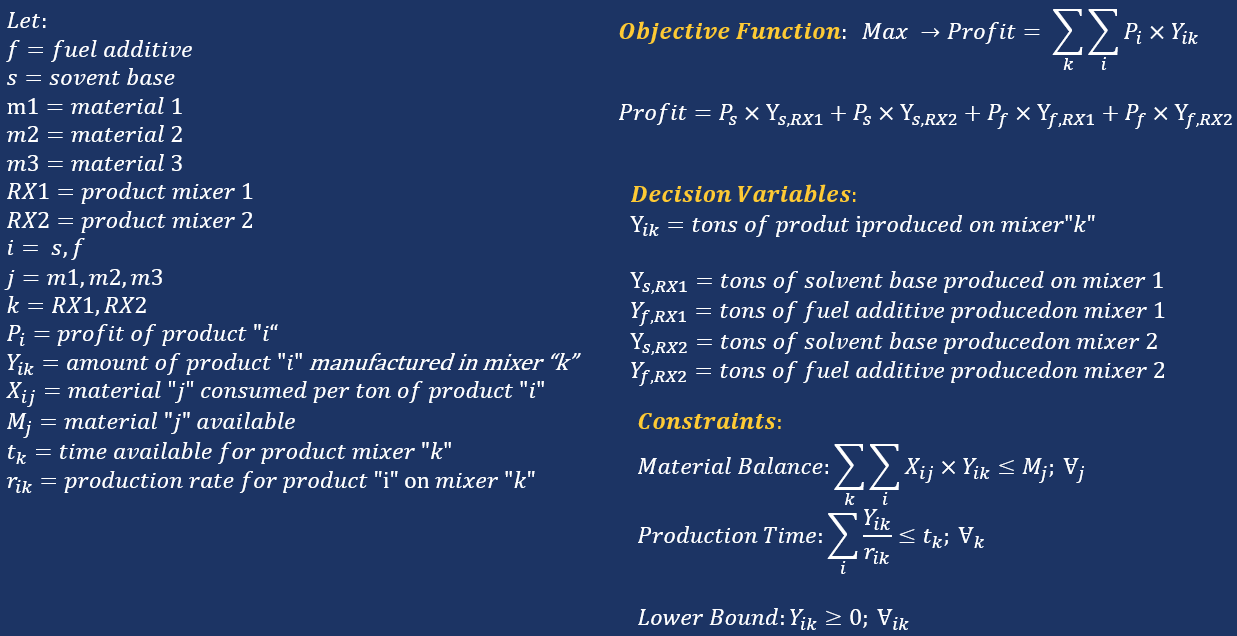

In [1]:
import pandas as pd
import numpy as np
import pulp

In [2]:
#read in data
data_prd = pd.read_excel("3_1_Data.xlsx","Products")
data_mat= pd.read_excel("3_1_Data.xlsx","Materials")
data_rec= pd.read_excel("3_1_Data.xlsx","Recipe")
data_mxr= pd.read_excel("3_1_Data.xlsx","Mixers_Rate")
data_cap= pd.read_excel("3_1_Data.xlsx","Mixers_Capacity")
data_prd

,Product,Price
0,s,38
1,f,40


In [3]:
data_mat

,Material,Available
0,m1,20
1,m2,5
2,m3,21


In [4]:
data_rec

,Product,Material,Cons
0,s,m1,0.5
1,s,m2,0.2
2,s,m3,0.3
3,f,m1,0.4
4,f,m2,0.0
5,f,m3,0.6


In [5]:
data_mxr

,Mixer,Product,Rate
0,RX1,s,0.65
1,RX1,f,0.50
2,RX2,s,0.60
3,RX2,f,0.45


In [6]:
data_cap

,Mixer,Time
0,RX1,30
1,RX2,24


In [7]:
#define input parameter values
products=list(data_prd['Product'].unique())
materials=list(data_mat['Material'].unique())
mixers=list(data_cap['Mixer'].unique())

X={}
for p in products:
    X[p]=dict(zip(materials,[None]*len(materials)))
for i in data_rec.index:
    X[data_rec.loc[i,'Product']][data_rec.loc[i,'Material']]=data_rec.loc[i,'Cons']

M=dict(zip(materials,[None]*len(materials)))
for i in data_mat.index:
    M[data_mat.loc[i,'Material']]=data_mat.loc[i,'Available']
    
P=dict(zip(products,[None]*len(products)))
for i in data_prd.index:
    P[data_prd.loc[i,'Product']]=data_prd.loc[i,'Price']
    
r={}
for p in products:
    r[p]=dict(zip(mixers,[None]*len(mixers)))
for i in data_mxr.index:
    r[data_mxr.loc[i,'Product']][data_mxr.loc[i,'Mixer']]=data_mxr.loc[i,'Rate']
    
t=dict(zip(mixers,[None]*len(mixers)))
for i in data_cap.index:
    t[data_cap.loc[i,'Mixer']]=data_cap.loc[i,'Time']

In [8]:
X

{'s': {'m1': 0.5, 'm2': 0.2, 'm3': 0.3},
 'f': {'m1': 0.4, 'm2': 0.0, 'm3': 0.6}}

In [9]:
M

{'m1': 20, 'm2': 5, 'm3': 21}

In [10]:
P

{'s': 38, 'f': 40}

In [11]:
r

{'s': {'RX1': 0.65, 'RX2': 0.6}, 'f': {'RX1': 0.5, 'RX2': 0.45}}

In [12]:
t

{'RX1': 30, 'RX2': 24}

## Build & Solve Model

In [13]:
#Step 1: Create Model Object
model = pulp.LpProblem("Production_Resourcing", pulp.LpMaximize)

In [14]:
#Step 2: Create Decision Variables
prd_index=[]
for p in products:
    for k in mixers:
        prd_index.append((p,k))

Y = pulp.LpVariable.dicts('Y', ((products,mixers) for products, mixers in prd_index), lowBound=0, cat='Continuous')
Y

{('s', 'RX1'): Y_('s',_'RX1'),
 ('s', 'RX2'): Y_('s',_'RX2'),
 ('f', 'RX1'): Y_('f',_'RX1'),
 ('f', 'RX2'): Y_('f',_'RX2')}

In [15]:
#Step 3: Add Objective Function
obj_fxn = 0
obj_fxn += pulp.lpSum([Y[p,k]*P[p] for p,k in prd_index])
model += obj_fxn

In [16]:
#Step 4: Add Constraints

for m in materials:
    model += sum([X[p][m]*Y[p,k] for p, k in prd_index]) <= M[m], 'Material Balance' +'_'+str(m)

for k in mixers:
    model += sum([Y[p,k]*(1/r[p][k]) for p in products]) <= t[k], 'Production Time' +'_'+str(k)
    
#NOTE we did note at the non-negative production constraints here because we already specificied them in th e"lowBound" of the LpVariable class. 

In [17]:
#Step 5: Write the Model
model.writeLP("lp_model.lp")

[Y_('f',_'RX1'), Y_('f',_'RX2'), Y_('s',_'RX1'), Y_('s',_'RX2')]

In [18]:
#Step 6: Solve Model
model.solve(pulp.PULP_CBC_CMD(msg=True, keepFiles=False))
pulp.LpStatus[model.status]

'Optimal'

## Evaluation & Sensitivity Analysis

In [19]:
# look at objective value
model.objective.value()

1223.846152

In [20]:
#create data frame for df_var
df_var=pd.DataFrame()
lp_class=[]
var=[]
val=[]
rc=[]
for j in model.variables():
    lp_class.append('var')
    var.append(j)
    val.append(j.varValue)
    rc.append(j.dj)

df_var['class']=lp_class
df_var['name']=var
df_var['val']=val
df_var['rc']=rc

df_var

,class,name,val,rc
0,var,"Y_('f',_'RX1')",6.846154,-0.000000
1,var,"Y_('f',_'RX2')",0.000000,-1.025641
2,var,"Y_('s',_'RX1')",10.600000,-0.000000
3,var,"Y_('s',_'RX2')",14.400000,-0.000000


In [21]:
#create data frame for df_const
df_const=pd.DataFrame()
lp_class=[]
const=[]
val=[]
slack=[]
dv=[]
for j in model.constraints.items():
    lp_class.append('constraint')
    const.append(j[0])
    val.append(sum([var.varValue * coefficient for var, coefficient in j[1].items()]))
    slack.append(j[1].slack)
    dv.append(j[1].pi)

df_const['class']=lp_class
df_const['name']=const
df_const['val']=val
df_const['slack']=slack
df_const['dv']=dv

df_const

,class,name,val,slack,dv
0,constraint,Material_Balance_m1,15.238462,4.761538,-0.000000
1,constraint,Material_Balance_m2,5.000000,-0.000000,36.153846
2,constraint,Material_Balance_m3,11.607692,9.392308,-0.000000
3,constraint,Production_Time_RX1,30.000000,-0.000000,20.000000
4,constraint,Production_Time_RX2,24.000000,-0.000000,18.461538
